In [1]:
from src.inference.segment_inference import inference
from PIL import Image 
from pytesseract import pytesseract 


In [2]:
output = inference('./test.jpg',model_path="./src/model/segment.onnx")

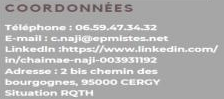

In [11]:
output[4].get('image')

In [13]:
path_to_tesseract = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

# img = Image.open(image_path) 


pytesseract.tesseract_cmd = path_to_tesseract 


text = pytesseract.image_to_string(output[6].get('image')) 

print(text[:-1])

DE 12 SEMAINES A PARTIR DU: 08/11/2021
SUsau Au: 26/02/2022


In [14]:
def extract_text(image_path):
    outputs = inference(image_path,model_path="./src/model/segment.onnx")
    result = {}
    for output in outputs:
        text = pytesseract.image_to_string(output.get('image'))
        result.update({output.get('label'):text})
    return result

In [15]:
extract_text('./test.jpg')

{'Experience': 'EXPERIENCE PROFESSIONNELLE\n',
 'Languages': '',
 'skills': 'OMPETEN:\n\n',
 'Name': 'Mme NAJI Chaimae\n',
 'Contact': '‘Telephone : 06-59.47.54.32\nE-mail: cnajighepmistes.net\nLinkedin shetpsd/unnaclinkedin.com/\ninfehaiense-riaji-OOsos7192\nbourgegnes, 95000 CuRGY\n\namecaGanaes SEANTA\n',
 'Education': 'FORMATION PROFESSIONNELLE\n\n',
 'Profil': "EN RECHERCHE D'UN STAGE TECHNICIEN EN\nan cuene\n"}